# Bayesian Machine Learning: Neural Net for Stellar Classification

Note: The majority of hypervelocity stars are of type B -- goal is to create a classification method to identify B type stars to make the search for high velocity stars less time consuming

Name: Devin McDonald 

Computing ID: djm6cz

## Imports

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import aesara
import aesara.tensor as T
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from collections import Counter
import astropy.table as at
from astropy.table import Table
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
np.random.seed(1629)

In [3]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', 50)

---

## Retrieving and Saving the Data

Uncomment out the following code to query the data necessary for the remainder of the notebook:

In [4]:
# def get_data(query):
    
#     job = Gaia.launch_job(query)
#     gaia_data = job.get_results()
#     gaia_data_df = gaia_data.to_pandas()  
   
#     return gaia_data_df

In [5]:
# query = '''SELECT TOP 300000 *
#   FROM gaiadr3.gaia_universe_model 
#   '''

In [6]:
# universe_model_df = get_data(query)

In [7]:
# t = Table.from_pandas(universe_model_df)

# t.write('Gaia-Universe-Model.fits', overwrite=True)
# new_table = Table.read('Gaia-Universe-Model.fits')

---

## EDA and Data Wrangling

In [8]:
# Load the data

fits = at.Table.read(r"/Users/devinmcdonald/Desktop/Bayes-Project/Gaia-Universe-Model.fits")
fits_df = fits.to_pandas()

In [9]:
# Number of rows and columns

print(fits_df.shape[0])
print(fits_df.shape[1])

300000
43


In [10]:
# Inspect the current columns of the df

fits_df.columns

Index(['source_extended_id', 'source_id', 'solution_id', 'ra', 'dec',
       'barycentric_distance', 'pmra', 'pmdec', 'radial_velocity', 'mag_g',
       'mag_bp', 'mag_rp', 'mag_rvs', 'v_i', 'mean_absolute_v', 'ag', 'av',
       'teff', 'spectral_type', 'logg', 'feh', 'alphafe', 'mbol', 'age',
       'mass', 'radius', 'vsini', 'population', 'has_photocenter_motion', 'nc',
       'nt', 'semimajor_axis', 'eccentricity', 'inclination',
       'longitude_ascending_node', 'orbit_period', 'periastron_date',
       'periastron_argument', 'variability_type', 'variability_amplitude',
       'variability_period', 'variability_phase', 'r_env_r_star'],
      dtype='object')

In [11]:
# Using only 'logg', 'teff' to predict 'spectral_type'

cols_of_interest = ['teff', 'logg', 'spectral_type']


df = fits_df.drop([x for x in fits_df.columns if x not in cols_of_interest], axis=1).dropna()

In [12]:
# Number of rows after droping NaNs

print(df.shape[0])

232080


In [13]:
# Take random sample of 100000 stars to cut down the size of the data

df = df.sample(100000, replace=False)

We will not be considering P and S type stars

In [14]:
np.unique([str(x)[2] for x in df.spectral_type])

array(['A', 'B', 'C', 'D', 'F', 'G', 'K', 'L', 'M', 'P', 'S'], dtype='<U1')

In [15]:
# All Included Spectral Types

spectral_classes_list = ['B', 'A', 'F', 'G', 'K', 'M', 'L', 'D']
spectral_classes_dict = {'B':0, 'A':1, 'F':2, 'G':3, 'K':4, 'M':5, 'L':6, 'D':7}

In [16]:
df.spectral_type = [str(x)[2] if str(x)[2] in spectral_classes_list else 'NULL' for x in df.spectral_type]

In [17]:
Counter(df.spectral_type)

Counter({'K': 23516,
         'G': 29028,
         'M': 20962,
         'F': 22012,
         'D': 2445,
         'L': 837,
         'A': 1012,
         'NULL': 68,
         'B': 120})

In [18]:
df = df[df.spectral_type != 'NULL'].reset_index().drop(['index'], axis=1)
df = df[df.teff <= 30000].reset_index().drop(['index'], axis=1)

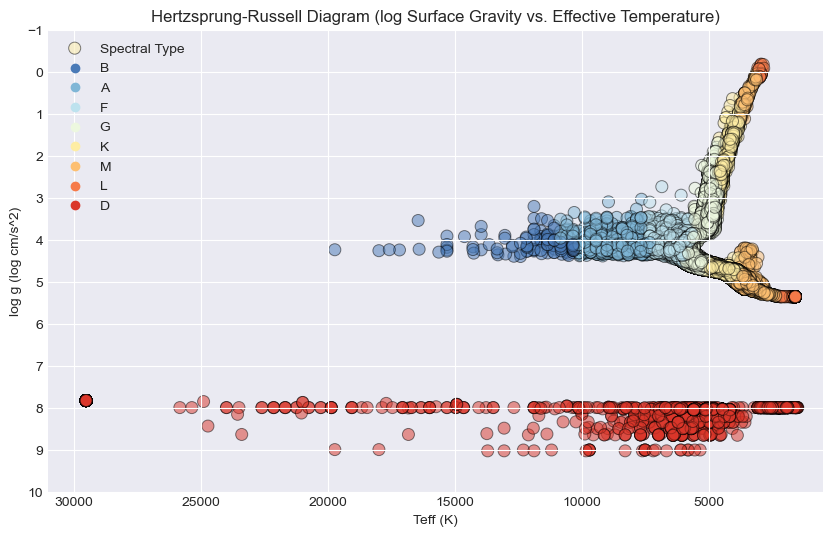

In [19]:
plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=df, x='teff', y='logg', hue='spectral_type', 
                     s=75, hue_order = spectral_classes_list, ec='black',
                     palette='RdYlBu_r', alpha=0.5, zorder=0, label="Spectral Type")

ax.set(xticks=np.arange(0,31000,5000), yticks=np.arange(-1,11,1))

plt.title('Hertzsprung-Russell Diagram (log Surface Gravity vs. Effective Temperature)')
plt.xlabel('Teff (K)')
plt.ylabel('log g (log cm/s^2)')
plt.xlim(31000, 500)
plt.ylim(10,-1)
plt.legend();

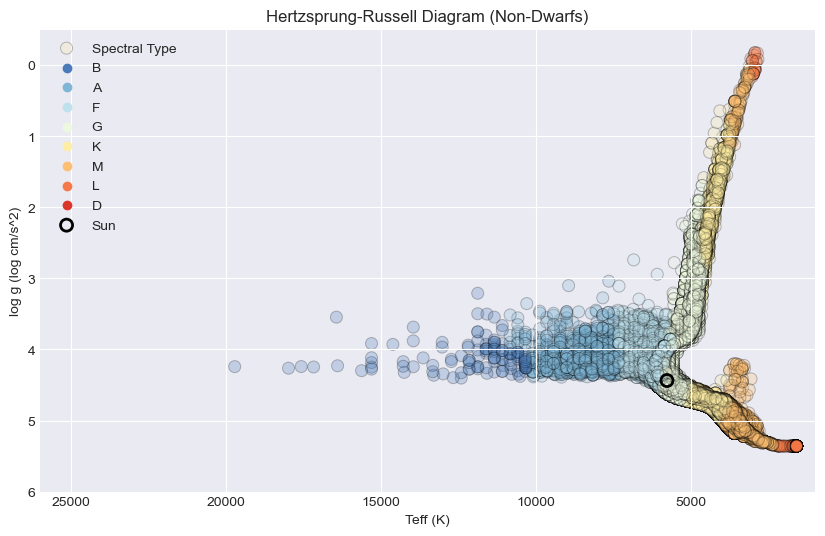

In [20]:
plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=df, x='teff', y='logg', hue='spectral_type', 
                     s=75, hue_order = spectral_classes_list, ec='black',
                     palette='RdYlBu_r', alpha=0.25, zorder=0, label="Spectral Type")

plt.scatter(5780, 4.4374, s=75, facecolor='none', lw=2, ec='black', zorder=1, label='Sun')

plt.title('Hertzsprung-Russell Diagram (Non-Dwarfs)')
plt.xlabel('Teff (K)')
plt.ylabel('log g (log cm/s^2)')
plt.xlim(26000, 1000)
plt.ylim(6,-0.5)
plt.legend();

### Sampling

Note: There are no O-type stars in the data set

In [21]:
# Actual Class Counts

O_prior = df[df.spectral_type=='O'].shape[0] / df.shape[0]
B_prior = df[df.spectral_type=='B'].shape[0] / df.shape[0]
A_prior = df[df.spectral_type=='A'].shape[0] / df.shape[0]
F_prior = df[df.spectral_type=='F'].shape[0] / df.shape[0]
G_prior = df[df.spectral_type=='G'].shape[0] / df.shape[0]
K_prior = df[df.spectral_type=='K'].shape[0] / df.shape[0]
M_prior = df[df.spectral_type=='M'].shape[0] / df.shape[0]
L_prior = df[df.spectral_type=='L'].shape[0] / df.shape[0]
D_prior = df[df.spectral_type=='D'].shape[0] / df.shape[0]

print("O: {} %".format(np.round((O_prior * 100), 3)) + '\n' +
      "B: {} %".format(np.round((B_prior * 100), 3)) + '\n' +
      "A: {} %".format(np.round((A_prior * 100), 3)) + '\n' +
      "F: {} %".format(np.round((F_prior * 100), 3)) + '\n' +
      "G: {} %".format(np.round((G_prior * 100), 3)) + '\n' +
      "K: {} %".format(np.round((K_prior * 100), 3)) + '\n' +
      "M: {} %".format(np.round((M_prior * 100), 3)) + '\n' +
      "L: {} %".format(np.round((L_prior * 100), 3)) + '\n' +
      "D: {} %".format(np.round((D_prior * 100), 3)) + '\n')

O: 0.0 %
B: 0.12 %
A: 1.016 %
F: 22.095 %
G: 29.138 %
K: 23.605 %
M: 21.041 %
L: 0.84 %
D: 2.144 %



In [22]:
# Replace spectral type string with integer

df.spectral_type = pd.Series(map(spectral_classes_dict.get, list(df.spectral_type)))

In [23]:
variable_of_interest = 'spectral_type'

In [24]:
x_data = df.drop([variable_of_interest], axis=1)
y_data = np.array(df[variable_of_interest])

### Standard Scaling

In [25]:
n_main = x_data.shape[0]
k_main = x_data.shape[1]

In [26]:
# Standard scale function

def standard_scale(DataFrame):
    
    df = DataFrame.copy(deep = True)
    
    mu = [np.mean(df[column]) for column in df.columns]
    sigma = [np.std(df[column]) for column in df.columns]
    
    
    for n in range(len(df.columns)):
        
        var = df.columns[n]
        df[var]=df[var].apply(lambda x: (x - mu[n]) / sigma[n])
            

    return(df)

In [27]:
# Standard scale numerical x data

x_data_scaled = standard_scale(x_data)
X = x_data_scaled.values.reshape((n_main,k_main))
Y = y_data

# Unscaled will be used later
X_unscaled = x_data.values.reshape((n_main,k_main))

### Train / Test Split

In [28]:
# Test train split (unscaled will be used later)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=.3, random_state=1629
)

X_train_unscaled, X_test_unscaled, Y_train_unscaled, Y_test_unscaled = train_test_split(
    X_unscaled, Y, test_size=.3, random_state=1629
)

In [73]:
len(df)

99623

### Oversampling

In [29]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train, Y_train)

Class=0, n=20299 (12.500%)
Class=1, n=20299 (12.500%)
Class=2, n=20299 (12.500%)
Class=3, n=20299 (12.500%)
Class=4, n=20299 (12.500%)
Class=5, n=20299 (12.500%)
Class=6, n=20299 (12.500%)
Class=7, n=20299 (12.500%)


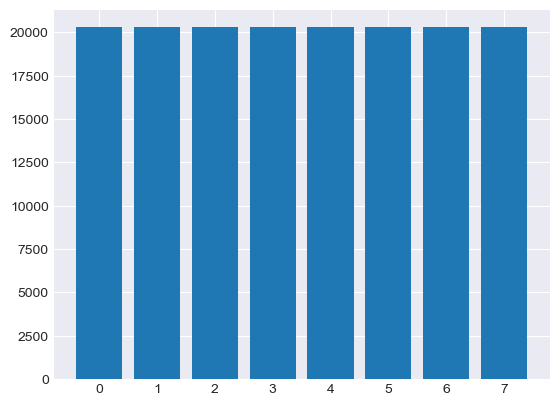

In [30]:
sorted_y = sorted(Y_train_OS)
counter = Counter(sorted_y)
for k,v in counter.items():
    per = v / len(Y_train_OS) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

In [31]:
# Set to astype(floatX)

floatX = aesara.config.floatX
X_train = X_train_OS.astype(floatX)
Y_train = Y_train_OS.astype(floatX)

In [32]:
# To see the dimensions of our data

print(X_train.shape)
print(Y_train.shape)

(162392, 2)
(162392,)


---

## Neural Network

Here we will use 2 hidden layers with 10 neurons each -- this should be sufficient given we are only considering two features

Bias initialized as 0

In [33]:
n_hidden = 10

# Initialize random weights between each layer
init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_bias_1 = np.zeros(n_hidden).astype(floatX)

init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_bias_2 = np.zeros(n_hidden).astype(floatX)

init_out = np.random.randn(n_hidden, 8).astype(floatX)
init_bias_out = np.zeros(8).astype(floatX)

with pm.Model() as neural_network:
  
    ann_input = aesara.shared(X_train)
    ann_output = aesara.shared(Y_train)

    # Weights from input to hidden layer
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X_train.shape[1], n_hidden), initval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(n_hidden), initval=init_bias_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), initval=init_2)
    bias_in_2 = pm.Normal("b_in_2", 0, sigma=1, shape=(n_hidden), initval=init_bias_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden, 8), initval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1, shape=(8), initval=init_bias_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + bias_in_2)
    
    # Apply softmax activation function for multiclass problem
    act_out = T.nnet.softmax(pm.math.dot(act_2, weights_2_out) + bias_2_out, axis=-1)

    # Categorical classification
    out = pm.Categorical("out", act_out, observed=ann_output, total_size=X_train.shape[0])

In [34]:
b = 100

with neural_network:
    inference = pm.ADVI()
    X_batch = pm.Minibatch(X_train, batch_size=b)
    Y_batch = pm.Minibatch(Y_train, batch_size=b)
    approx = pm.fit(n=60000, method=inference, 
                    more_replacements={ann_input: X_batch, ann_output: Y_batch}) 

Finished [100%]: Average Loss = 10.013


In [35]:
tot_batches = len(X_train) / b
iterations_per_epoch = tot_batches
tot_iterations = 60000

epochs = tot_iterations / iterations_per_epoch
epochs

36.94763288831962

As we can see the ELBO converges nicely:

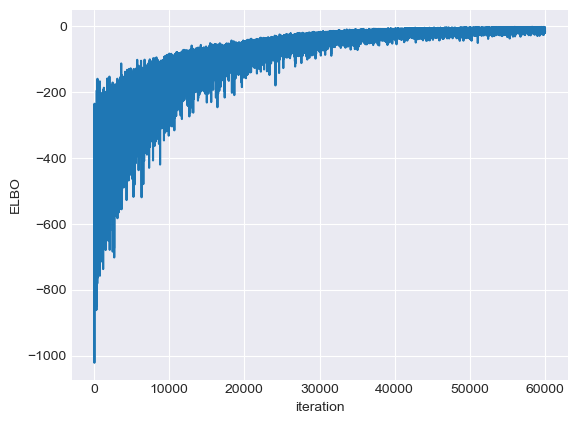

In [36]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

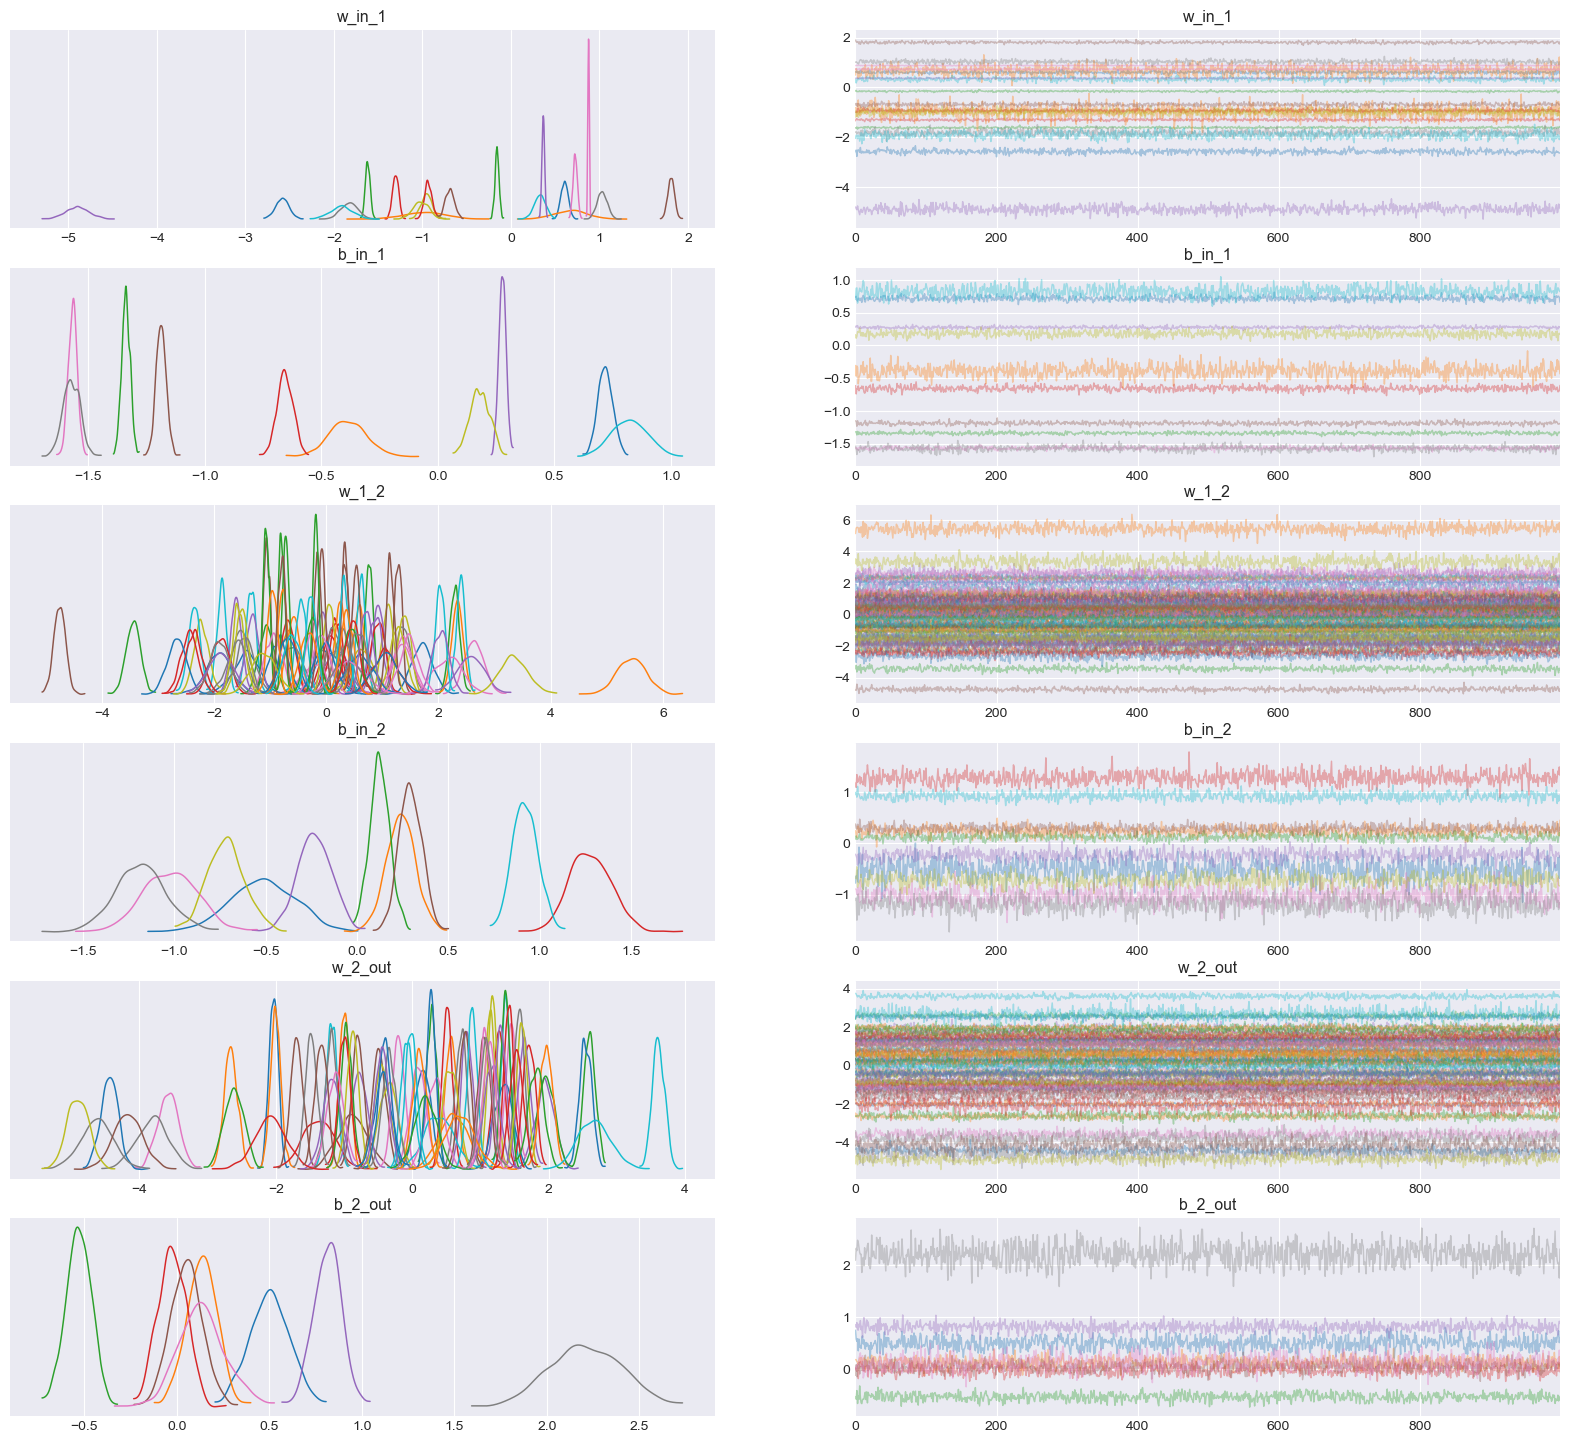

In [37]:
samples = 1000

with neural_network:
    trace = approx.sample(samples)
    pm.plot_trace(trace, compact=True, figsize=(20,18));

In [38]:
# Replace arrays in our NN references with the test data

ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, progressbar=True)

In [39]:
ppc.posterior_predictive.out

<xarray.DataArray 'out' (chain: 1, draw: 1000, out_dim_0: 29887)>
array([[[2, 4, 5, ..., 4, 3, 3],
        [2, 4, 5, ..., 4, 3, 3],
        [3, 4, 5, ..., 4, 3, 3],
        ...,
        [2, 4, 5, ..., 4, 3, 3],
        [2, 4, 5, ..., 4, 3, 3],
        [2, 4, 5, ..., 4, 3, 3]]])
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * out_dim_0  (out_dim_0) int64 0 1 2 3 4 5 ... 29882 29883 29884 29885 29886

---

## Results

In [40]:
pred = np.array(ppc.posterior_predictive.out)

In [41]:
counts = []

for i in range(len(X_test)):
    
    for j in range(samples):
        
        counts.append(pred[0][j][i])
        
counts = np.array(counts).reshape(len(X_test), samples)

In [42]:
modes = []

for i in counts:
    modes.append(mode(i)[0][0])

In [43]:
result = (Y_test == modes).astype(int)
results_df = pd.DataFrame({'Y_test':Y_test,
                           'result':result})

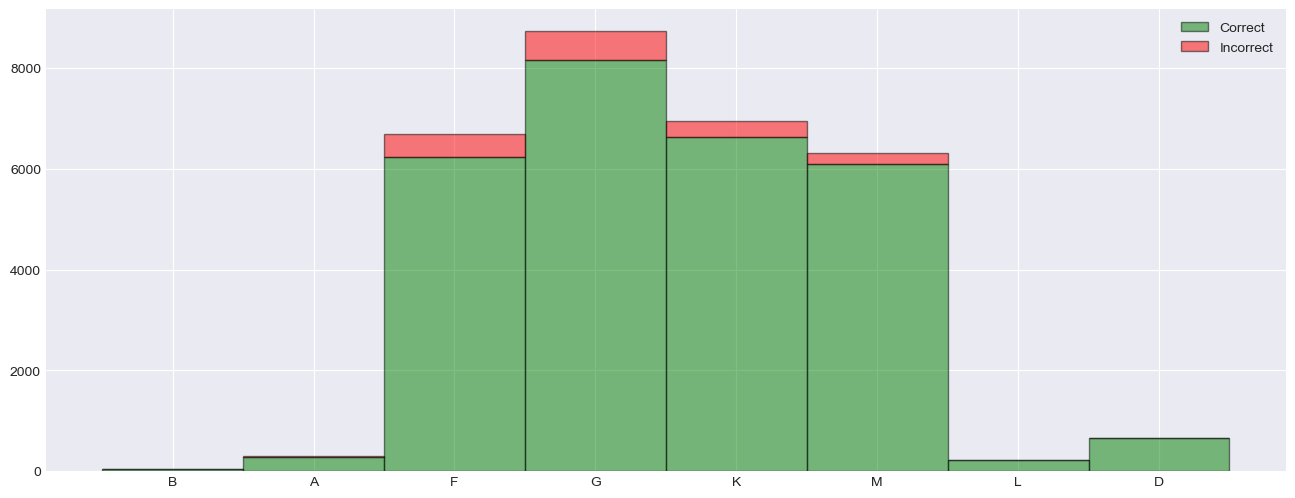

In [44]:
fig, ax = plt.subplots(figsize=(16,6))

# Predictions
n, bins, patches = plt.hist([results_df.Y_test[results_df.result==1], 
                             results_df.Y_test[results_df.result==0]], 
                             bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],
                             alpha=0.5, histtype='bar', ec='black', 
                             label=['Correct', 'Incorrect'], color=['green', 'red'], stacked=True)


xticks = [0,1,2,3,4,5,6,7]
ax.set_xticks(xticks, labels=spectral_classes_list)
plt.legend(loc='upper right')
# plt.ylim(0,5000)
plt.xticks()
plt.show()

In [45]:
# Calculate the accuracy based on the mode of class appearance

print('Accuracy = {}%'.format((Y_test == modes).mean().round(3) * 100))

Accuracy = 94.69999999999999%


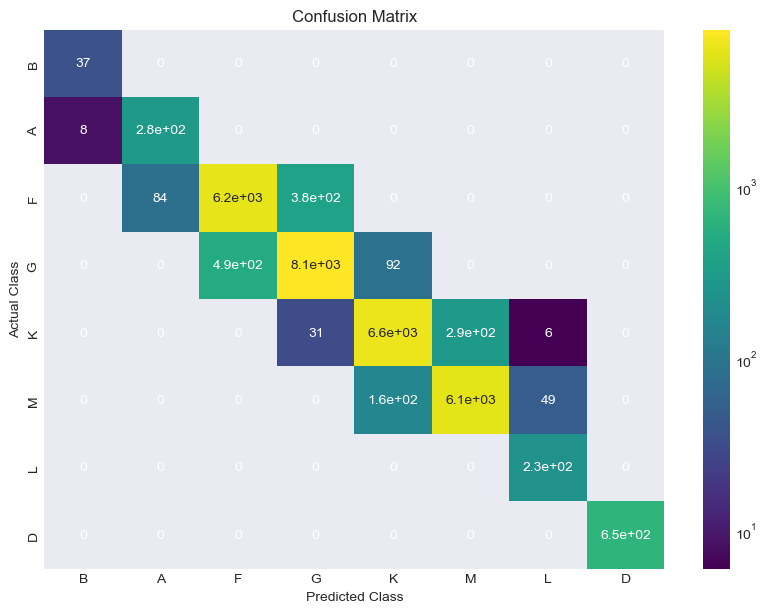

In [46]:
cm = confusion_matrix(Y_test, modes)
cm_df = pd.DataFrame(cm,
                     index = spectral_classes_list, 
                     columns = spectral_classes_list)

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='viridis', vmin=0, vmax=8000, norm=LogNorm())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

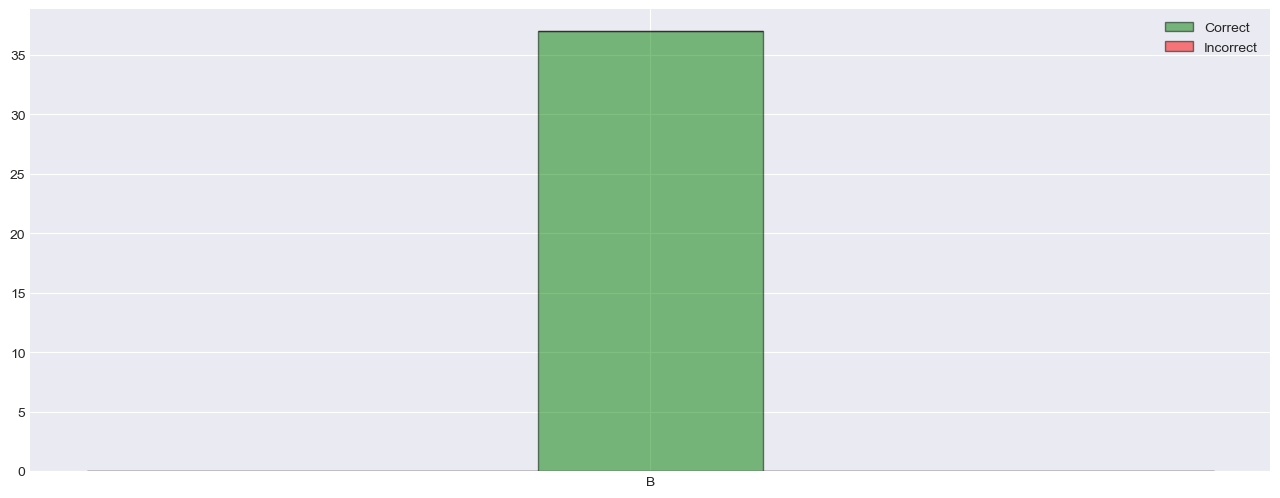

In [47]:
fig, ax = plt.subplots(figsize=(16,6))

# Predictions
n, bins, patches = plt.hist([results_df.Y_test[(results_df.Y_test==0) & (results_df.result==1)], 
                             results_df.Y_test[(results_df.Y_test==0) & (results_df.result==0)]], 
                             bins=[-2.5,-1.5,-0.5,0.5,1.5,2.5],
                             alpha=0.5, histtype='bar', ec='black', 
                             label=['Correct', 'Incorrect'], color=['green', 'red'], stacked=True)


xticks = [0]
ax.set_xticks(xticks, labels=spectral_classes_list[0])
plt.legend(loc='upper right')
plt.xticks()
plt.show()

In [48]:
b_correct = len(results_df.Y_test[(results_df.Y_test==0) & (results_df.result==1)])
b_incorrect = len(results_df.Y_test[(results_df.Y_test==0) & (results_df.result==0)])

In [49]:
# Calculate the accuracy based on the mode of class appearance

print('Accuracy = {}%'.format((b_correct / (b_correct + b_incorrect)) * 100))

Accuracy = 100.0%


---

## Further Analysis

In [50]:
counts_df = pd.DataFrame(counts).mode(axis=1).drop([1], axis=1)
counts_df;

In [51]:
inv_map = {v: k for k, v in spectral_classes_dict.items()}

In [52]:
pred_test_unscaled_df = pd.DataFrame(X_test_unscaled).rename(columns={0:'X', 1:'Y'})
pred_test_unscaled_df['pred_class'] = counts_df.astype(int)
pred_test_unscaled_df.pred_class = pd.Series(map(inv_map.get, list(pred_test_unscaled_df.pred_class)))

pred_test_df = pd.DataFrame(X_test).rename(columns={0:'X', 1:'Y'})
pred_test_df['pred_class'] = counts_df.astype(int)
pred_test_df.pred_class = pd.Series(map(inv_map.get, list(pred_test_df.pred_class)))

true_test_df = pd.DataFrame(X_test_unscaled).rename(columns={0:'X', 1:'Y'})
true_test_df['true_class'] = Y_test.astype(int)
true_test_df.true_class = pd.Series(map(inv_map.get, list(Y_test)))

In [53]:
pred_test_unscaled_df;

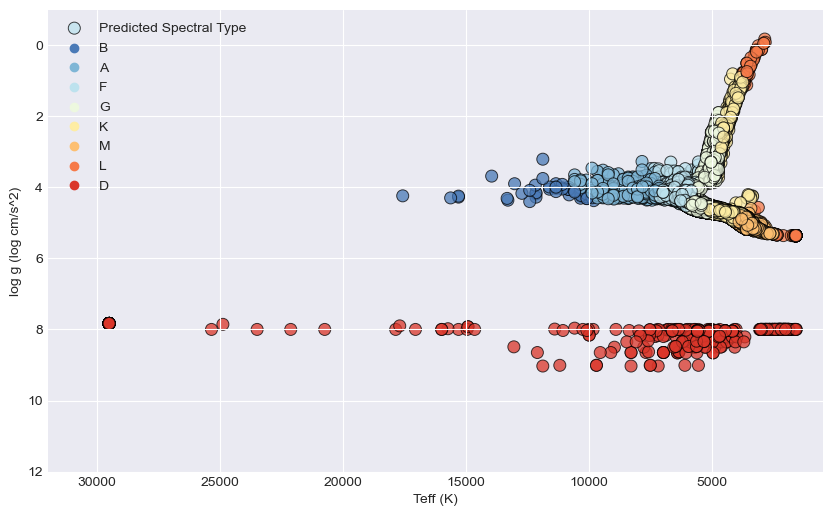

In [54]:
plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=pred_test_unscaled_df, x='X', y='Y', hue='pred_class', s=75,
                     hue_order=spectral_classes_list, palette='RdYlBu_r', 
                     ec='black', alpha=0.75, zorder=0, label="Predicted Spectral Type")

plt.xlabel('Teff (K)')
plt.ylabel('log g (log cm/s^2)')
plt.xlim(32000, 500)
plt.ylim(12,-1)
plt.legend();

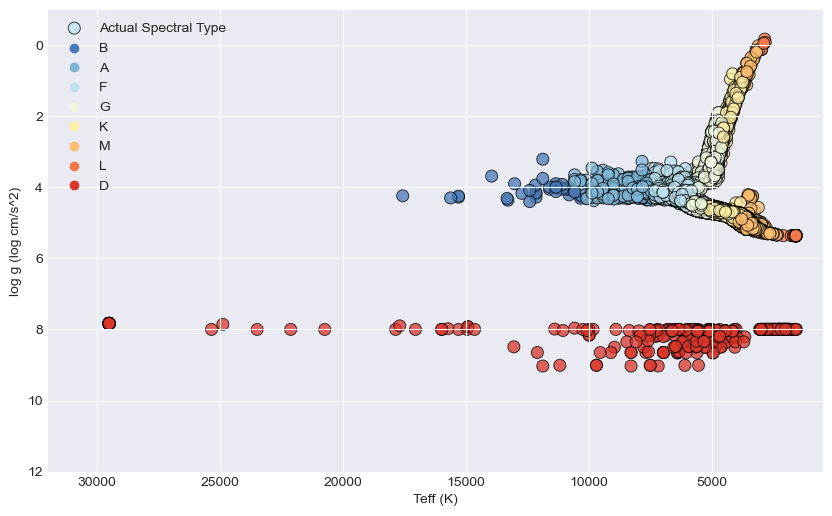

In [55]:
plt.figure(figsize=(10,6))

ax = sns.scatterplot(data=true_test_df, x='X', y='Y', hue='true_class', s=75,
                     hue_order = spectral_classes_list, palette='RdYlBu_r', 
                     ec='black', alpha=0.75, zorder=0, label="Actual Spectral Type")

plt.xlabel('Teff (K)')
plt.ylabel('log g (log cm/s^2)')
plt.xlim(32000, 500)
plt.ylim(12,-1)
plt.legend();

## Class Contour

In [56]:
# min and max of x dimension

min_x = min(pd.DataFrame(X_train)[0])
max_x = max(pd.DataFrame(X_train)[0])

In [57]:
# min and max of y dimension

min_y = min(pd.DataFrame(X_train)[1])
max_y = max(pd.DataFrame(X_train)[1])

In [58]:
# grid = pm.floatX(np.mgrid[18000:2000:100j,14:-5:100j])

grid = pm.floatX(np.mgrid[min_x:max_x:100j,min_y:max_y:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [59]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, progressbar=True)

In [60]:
ppc_array = np.array(ppc.posterior_predictive.out[0])

In [61]:
ppc_array.shape

(1000, 10000)

In [62]:
ppc_modes = pd.DataFrame(ppc_array).mode(axis=0).drop(1)

modes_contour = np.array(ppc_modes).reshape(100,100)

**Mode Contour**

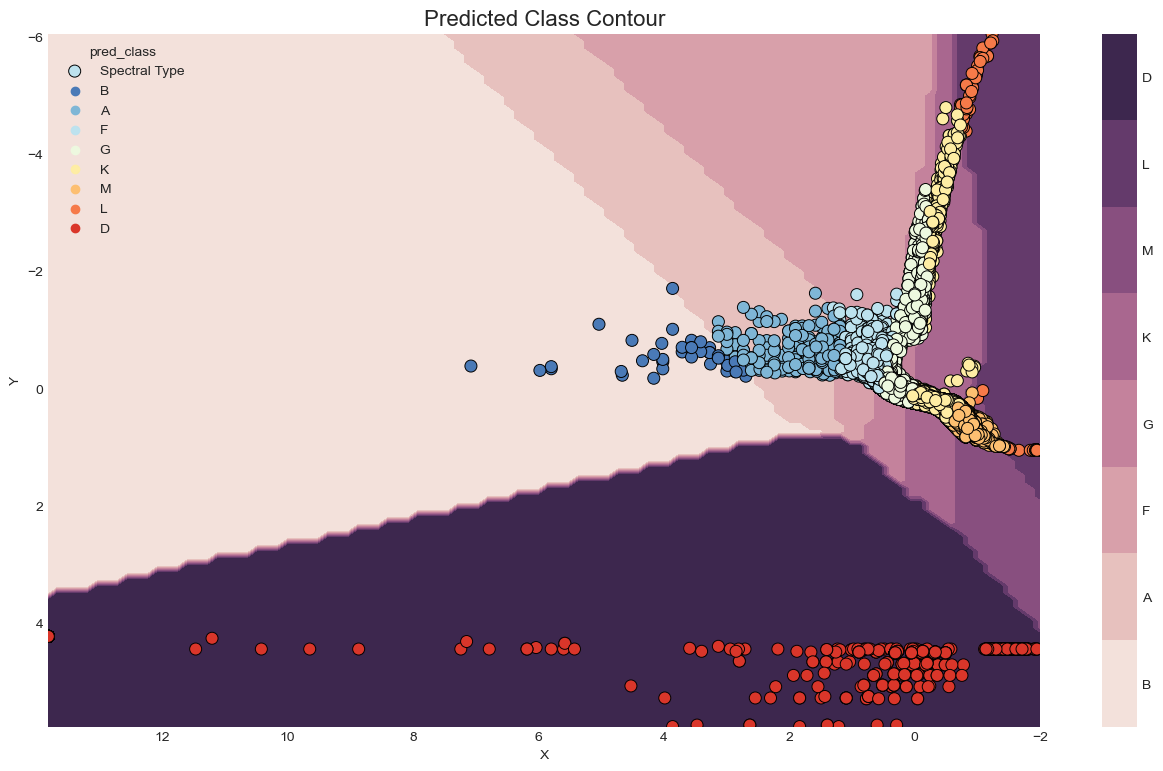

In [63]:
cmap = sns.cubehelix_palette(light=0.95, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], modes_contour, levels=[-0.5,0.5,1.5,2.5,3.5,
                                                                4.5,5.5,6.5,7.5], cmap=cmap)

sns.scatterplot(data=pred_test_df, x='X', y='Y', hue='pred_class', s=75,
                     hue_order=spectral_classes_list, ec='black',
                     palette='RdYlBu_r', alpha=1, label="Spectral Type")

cbar = plt.colorbar(contour, ax=ax, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(spectral_classes_list)
_ = ax.set(xlim=(max_x, min_x), ylim=(max_y, min_y), xlabel='X', ylabel='Y')
plt.title('Predicted Class Contour', fontsize=16);

**Overall Standard Deviation Contour**

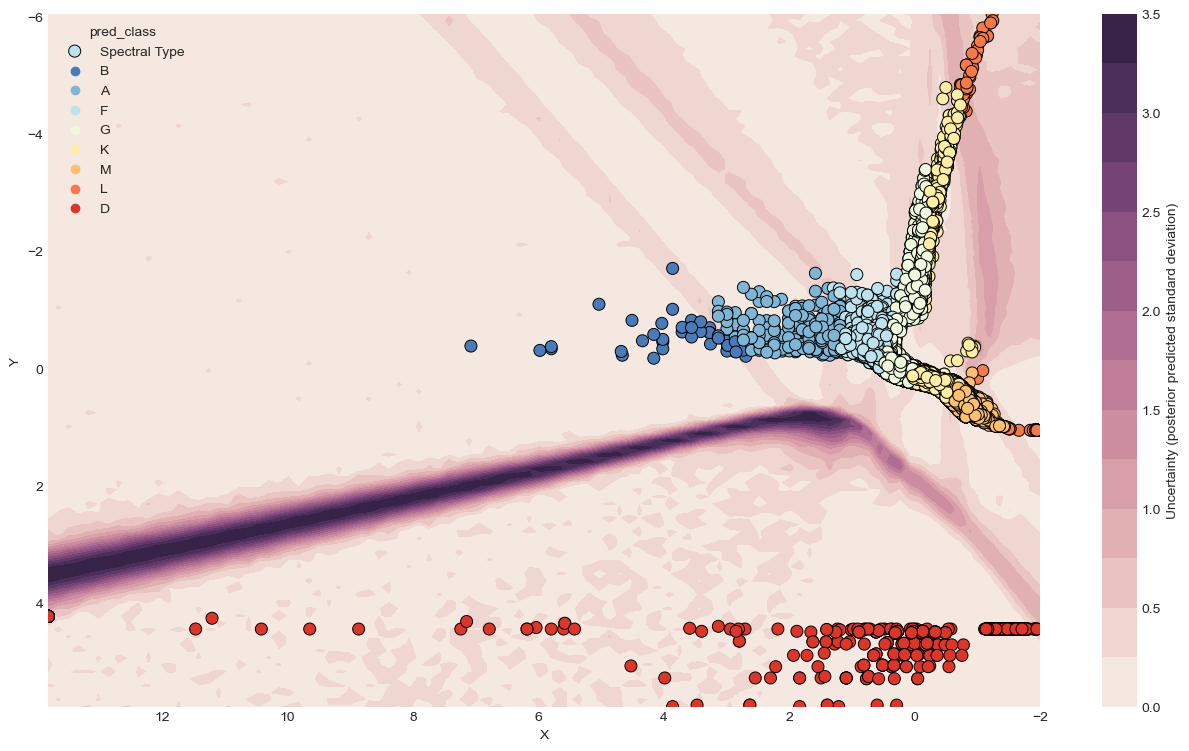

In [64]:
cmap = sns.cubehelix_palette(light=0.95, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc_array.std(axis=0).reshape(100, 100), 16,
                      cmap=cmap)

sns.scatterplot(data=pred_test_df, x='X', y='Y', hue='pred_class', s=75,
                     hue_order = spectral_classes_list, ec='black',
                     palette='RdYlBu_r', alpha=1, label="Spectral Type")

cbar = plt.colorbar(contour, ax=ax, label='Uncertainty (posterior predicted standard deviation)')
_ = ax.set(xlim=(max_x, min_x), ylim=(max_y, min_y), xlabel='X', ylabel='Y')

## B-type Uncertainty (Std)

In [65]:
stellar_class = 0

In [66]:
b_class = np.array([1 if x == stellar_class else 0 for x in ppc_array.flatten()]).reshape(1000, 10000)
b_class_trial = pd.DataFrame(b_class).std(axis=0)
b_contour = np.array(b_class_trial).reshape(100,100)

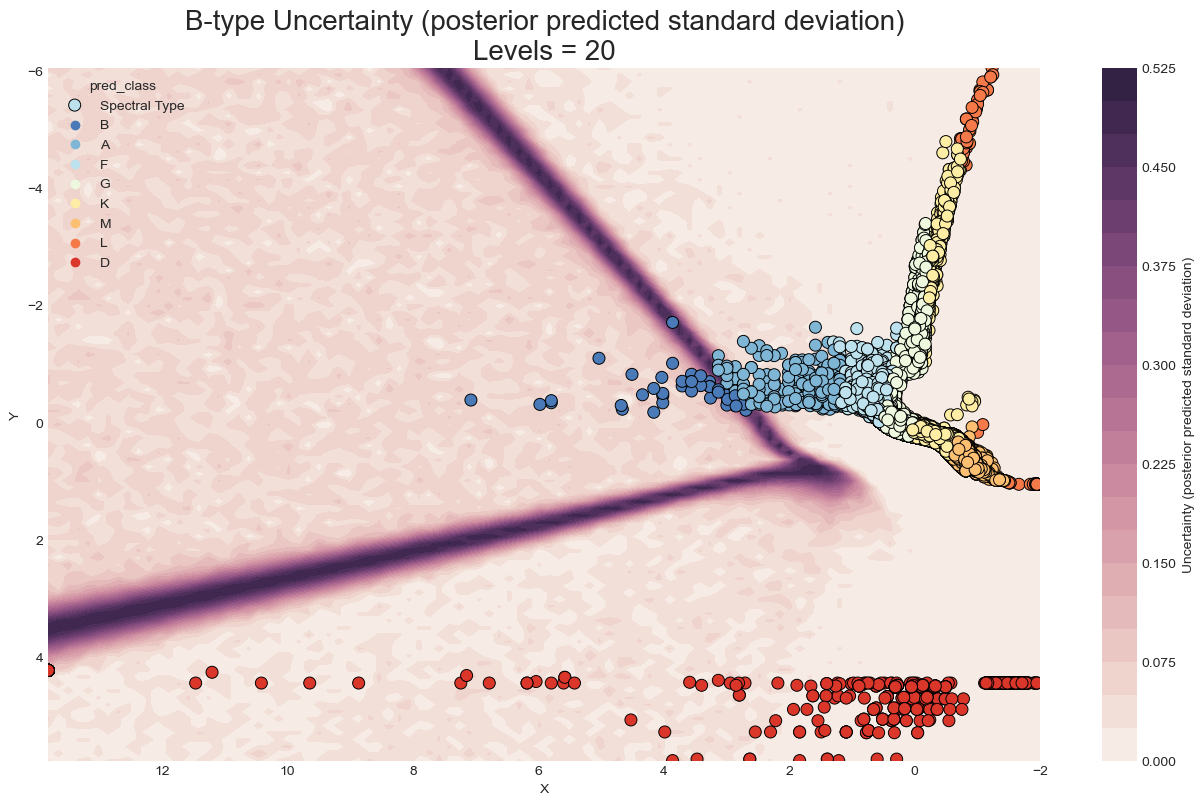

In [67]:
# cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
# fig, ax = plt.subplots(figsize=(16, 9))

cmap = sns.cubehelix_palette(light=0.95, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], b_contour, 20, cmap=cmap)

sns.scatterplot(data=pred_test_df, x='X', y='Y', hue='pred_class', s=75,
                     hue_order = spectral_classes_list, ec='black',
                     palette='RdYlBu_r', alpha=1, label="Spectral Type", legend=True)

cbar = plt.colorbar(contour, ax=ax, label='Uncertainty (posterior predicted standard deviation)')
_ = ax.set(xlim=(max_x, min_x), ylim=(max_y, min_y), xlabel='X', ylabel='Y')
plt.title('B-type Uncertainty (posterior predicted standard deviation)' + '\n' + 'Levels = 20',
         fontsize=20);

---